# WOfS anomalies averaged over polygons

## Load packages, connect to datacube

In [1]:
%matplotlib inline

import datacube
import gc
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from datacube.utils import geometry
import pandas as pd
import matplotlib as mpl
import xarray as xr
from odc.algo import xr_reproject
from datacube.utils.geometry import assign_crs

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.dask import create_local_dask_cluster

dc = datacube.Datacube(app="WOfS-figure")

import warnings
warnings.filterwarnings("ignore", message="Iteration over multi-part geometries is deprecated and will be removed in ")

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [ ]:
create_local_dask_cluster()

## Analysis parameters

* `year`: The year the anomaly will be calculated for ie, if '2020' then the WOfS area for 2020 will be subtracted from the long-term mean
* `vector_file`: The shapefile (geojson) over which the anomalies are iterated. The final results are appended to this dataframe on this file
* `attribute_col`: the column in the "vector_file" that is used to label the results. ie if this is a shapefile with Africam country boundary then the attribute_col should be the column containg the country names
* `output_suffix`: a filename suffix added to the exported  results geojson to identify what the results refer to. ie. if iterating over African countries then make this parameter something like 'countries'. 

In [4]:
# Set the year you want to compare
year = '2022'
clim_year='2000','2020'
vector_file = "data/african_countries.shp"
attribute_col = 'name'
output_suffix = 'countries'
wofs_threshold = 0.30

## Open vector file and set-up ODC query

In [ ]:
gdf = gpd.read_file(vector_file)
gdf.head()

In [ ]:
measurements = ['frequency']
resolution = (-30,30)
output_crs = 'EPSG:6933'

In [ ]:
query = {'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         'dask_chunks':dict(x=1000,y=1000)
         }

### Loop through polygons and process WOfS data



In [ ]:
#store results in dict
year_area = {}
area_mean = {}
area_std = {}
area_min = {}
area_idxmin = {}
area_max = {}
area_idxmax = {}
diff = {}
change_perc = {}
anomaly = {}

In [ ]:
# Try to prevent garbage collection warning from dask
g0, g1, g2 = gc.get_threshold()
gc.set_threshold(g0*3, g1*3, g2*3)

# A progress indicator
i = 0

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():

    print(" Feature {:02}/{:02}\r".format(i + 1, len(gdf)),
          end='')

    country = str(row[attribute_col])

    # Get the geometry
    geom = geometry.Geometry(row.geometry.__geo_interface__,
                             geometry.CRS(gdf.crs))

    # Update dc query with geometry
    query.update({'geopolygon': geom})

    # Load wofs
    ds = dc.load(product='wofs_ls_summary_annual',
                 time=(clim_year[0], year),
                 **query)

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds, verbose=False)
    ds = ds.where(mask)

    # threshold
    ds = ds.frequency >= wofs_threshold

    # calculate area of pixels
    area_per_pixel = query["resolution"][1]**2 / 1000**2
    ds_area = (ds.sum(dim=['x', 'y']) * area_per_pixel).compute()

    # Save timeseries of water area for reference
    plt.ioff()  # turn off plotting
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    ds_area.plot(ax=ax, marker='o', color='#9467bd')
    plt.title(f'Observed Annual Area of Water :'+country+f', {clim_year[0]} to {clim_year[1]}')
    plt.xlabel('Year')
    plt.ylabel('Waterbody area (km$^2$)')
    plt.tight_layout()
    fig.savefig('results/pngs/wofs/wofs_area_'+country+f'_{clim_year[0]}_{clim_year[0]}.png',
                bbox_inches='tight',
                dpi=200,
                facecolor="white")
    plt.close(fig)

    # summary stats for area of water from 1984-2020
    ds_clim_area = ds_area.sel(time=slice(clim_year[0], clim_year[1]))
    ds_area_mean = ds_clim_area.mean().values.item()
    ds_area_std = ds_clim_area.std().values.item()
    ds_area_max = ds_clim_area.max().values.item()
    ds_area_idxmax = int(ds_clim_area.idxmax().dt.year.values)
    ds_area_min = ds_clim_area.min().values.item()
    ds_area_idxmin = int(ds_clim_area.idxmin().dt.year.values)

    # area in year of interest
    ds_area_year = ds_area.sel(time=year).values.item()

    # compare area
    diff_area = ds_area_year - ds_area_mean
    diff_percent = diff_area / ds_area_mean * 100
    anomaly_year = (ds_area_year - ds_area_mean) / ds_area_std

    # output results in dict
    year_area.update({country: ds_area_year})
    area_mean.update({country: ds_area_mean})
    area_std.update({country: ds_area_std})
    area_max.update({country: ds_area_max})
    area_min.update({country: ds_area_min})
    area_idxmin.update({country: ds_area_idxmin})
    area_idxmax.update({country: ds_area_idxmax})
    diff.update({country: diff_area})
    change_perc.update({country: diff_percent})
    anomaly.update({country: anomaly_year})
    i += 1

## Concatenate results in a dataframe

In [ ]:
df = pd.DataFrame.from_dict(
    [
        year_area,
        area_mean,
        area_std,
        area_max,
        area_min,
        area_idxmax,
        area_idxmin,
        diff,
        change_perc,
        anomaly,
    ]
).T.rename(
    {
        0: "Water Extent " + year + " (km2)",
        1: f"Mean Water Extent {clim_year[0]}-{clim_year[1]} (km2)",
        2: f"Std. Dev. Water Extent {clim_year[0]}-{clim_year[1]} (km2)",
        3: f"Max Water Extent {clim_year[0]}-{clim_year[1]} (km2)",
        4: f"Min Water Extent {clim_year[0]}-{clim_year[1]} (km2)",
        5: f"Year of Max Water Extent {clim_year[0]}-{clim_year[1]}",
        6: f"Year of Min Water Extent {clim_year[0]}-{clim_year[1]}",
        7: "Difference in Water Extent: " + year + " - Mean (km2)",
        8: "Percentage Difference in Water Extent: " + year + " - Mean",
        9: "Standardised Anomaly in Water Extent: (" + year + " - Mean) / Std.dev.",
    },
    axis=1,
)

df.head()

## Join results onto geodataframe and export

In [ ]:
gdf = gdf.join(df, attribute_col)

In [ ]:
gdf.to_file('results/geojsons/wofs_anomalies_africa_'+output_suffix+'_'+year+'.geojson')

## Explore results

You can read in the geojson if returning to this notebook by uncommenting the cell directly below.

The geodataframe is 'simplified' to speed up processing.

Change the `col_to_plot` parameter to change which variable is plotted


In [ ]:
# gdf = gpd.read_file('results/geojsons/wofs_anomalies_africa_'+output_suffix+'_'+year+'.geojson')

In [ ]:
gdf.columns

In [ ]:
#simplify so plotting is fast
gdf_simple = gdf.to_crs('epsg:6933')
gdf_simple['geometry'] = gdf_simple['geometry'].simplify(2500)


In [ ]:
col_to_plot = "Mean Water Extent 2000-2020 (km2)"

gdf_simple.explore(
    column=col_to_plot,
    cmap="plasma",
#     vmin=-3.0,
    vmax=45000,
    style_kwds={"fillOpacity": 1.0},
    tiles="CartoDB positron",
)

# ------FIGURES CODE ----------------------------------------------

### Plot WOfS with country boundaries
**Use this section to edit existing plot title, bounds, etc.**

If you have successfully exported the previous shapefile but started a new instance, there is no need to re-process the data. It can be read in from the shapefile by uncommenting and running the code below. Be sure the vector file path is to the correct shapefile title.

In [5]:
gdf = gpd.read_file('results/geojsons/wofs_anomalies_africa_'+output_suffix+'_'+year+'.geojson')

In [12]:
gdf.head()

,name,Water Extent 2022 (km2),Mean Water Extent 2000-2020 (km2),Std. Dev. Water Extent 2000-2020 (km2),Max Water Extent 2000-2020 (km2),Min Water Extent 2000-2020 (km2),Year of Max Water Extent 2000-2020,Year of Min Water Extent 2000-2020,Difference in Water Extent: 2022 - Mean (km2),Percentage Difference in Water Extent: 2022 - Mean,Standardised Anomaly in Water Extent: (2022 - Mean) / Std.dev.,geometry
0,Sudan,5416.7517,4408.508657,643.539104,5560.8057,3457.2969,2019.0,2002.0,1008.243043,22.870388,1.566716,"MULTIPOLYGON (((38.58148 18.02542, 38.58203 18..."
1,Angola,2354.7366,3573.678257,2281.595628,11269.8963,1972.9908,2011.0,2019.0,-1218.941657,-34.108881,-0.534250,"MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -..."
2,Benin,266.2812,236.257843,29.078108,301.4379,187.2171,2003.0,2000.0,30.023357,12.707877,1.032507,"MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288..."
3,Botswana,1204.6698,2343.555429,1027.646994,4759.3737,607.8114,2017.0,2003.0,-1138.885629,-48.596488,-1.108246,"POLYGON ((25.17447 -17.77881, 25.18476 -17.783..."
4,Burkina Faso,1314.0153,927.779914,134.645628,1227.4614,732.8286,2020.0,2000.0,386.235386,41.630065,2.868533,"POLYGON ((-0.45567 15.08082, -0.45411 15.07937..."


In [9]:
col_to_plot = f"Standardised Anomaly in Water Extent: ({year} - Mean) / Std.dev."

### Customise the plot

In [10]:
vmin, vmax = -3,3.1
steps = 0.5
title = f'Standardised Anomaly in Surface Water Extent {year}'
export_path = f'results/pngs/wofs/std_anomaly_wofs_{year}.png'

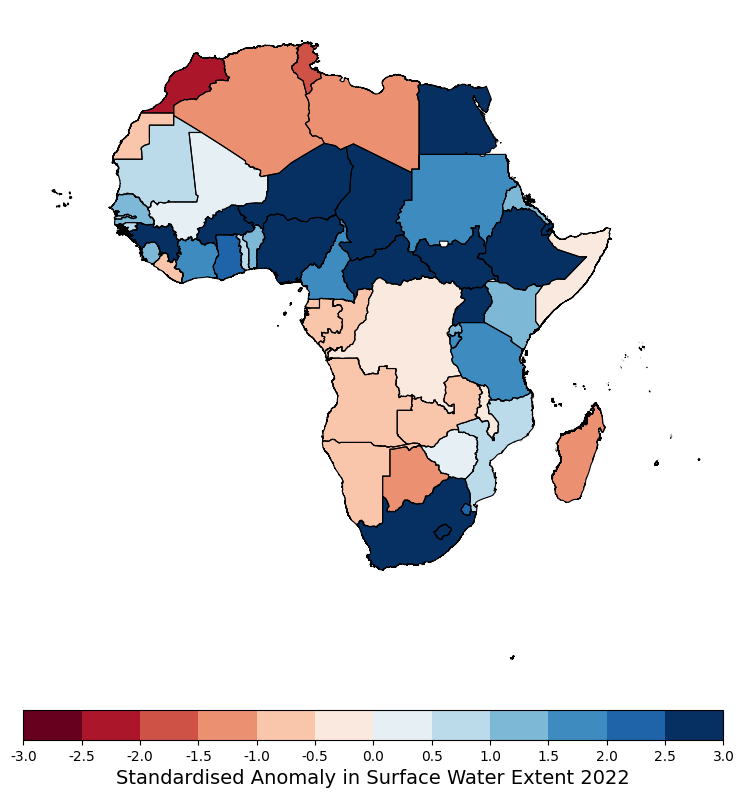

In [11]:
# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.RdBu
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:2}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plot 'pc_change' and 'geometry' boundary lines
gdf.plot(col_to_plot, ax=ax, cmap=cmap, norm=norm)
gdf.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none")

# Export figure
fig.savefig(export_path, 
            bbox_inches='tight',
            dpi=200, 
            facecolor="white")

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')